<a href="https://colab.research.google.com/github/seolibek/Tufts2024/blob/main/umap_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:

!pip install umap-learn

In [91]:
import numpy as np
import random
import matplotlib.pyplot as plt
import umap
from PIL import Image, ImageOps
import seaborn as sns
from scipy.optimize import nnls
from skimage.feature import peak_local_max
import ipywidgets as widgets
from ipywidgets import interactive
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd

# UMAP on HSI data - SalinasA

Below is the first attempt at working with UMAP.

Notes:
UMAP accepts a two dimensional image. Thus, for example, when it works with MNIST, it just accepts MNIST.data. (See: documentation)

In our case, with HSI, there are three dimensions. We seek to extend the application of 2D images and UMAP to HSI imagery.



In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
cd MyDrive

[Errno 2] No such file or directory: 'MyDrive'
/content


Below, we load in our dataset.

This is a rewritten version of the MATLAB script from prewritten works (notably, Dr. Murphy's linked repositories)

(Updated from the github version in my repository, to fix small casting errors consistent with typical errors in translation from MATLAB to Python).

In [121]:
#read in the data
import numpy as np
import scipy.io

def loadHSI(data_path, ground_truth_path, data_col, ground_truth_col):
  data = scipy.io.loadmat(data_path)
  HSI = data[data_col]

  data = scipy.io.loadmat(ground_truth_path)
  GT = data[ground_truth_col]

  M, N, D = HSI.shape
  n = M * N
  X = HSI.reshape((n, D))
  X = X.astype(np.float64)

  norms = np.sqrt(np.sum(X**2, axis = 0))
  X /= norms

  X += 1e-6 * np.random.randn(*X.shape)

  HSI = X.reshape((M, N, D))

  new_gt = np.zeros_like(GT)
  unique_classes = np.unique(GT)
  K = len(unique_classes)

  for k, uc in enumerate(unique_classes, start=1):
      new_gt[GT == uc] = k
  n = new_gt.size
  Y = new_gt.reshape((n, 1))
  GT = new_gt

  return X, M, N, D, HSI, GT, Y, n, K

In [95]:
salinasA_path = '/content/drive/MyDrive/SalinasA_corrected.mat'
salinasA_gt_path = '/content/drive/MyDrive/SalinasA_gt.mat'

X, M, N, D, HSI, GT, Y, n, K = loadHSI(salinasA_path, salinasA_gt_path, 'salinasA_corrected', 'salinasA_gt')

Sanity check: Shape of all data objects

In [96]:
print(HSI.shape)
print(GT.shape)


(83, 86, 204)
(83, 86)


Below is code that is typical of running the UMAP dimensionality reduction. We note that the HSI data is reshaped to fit the dimensionality needs of UMAP, but consider that it may cause improper clustering.

In [97]:
def umap_projection_2d(hsi_data):

  data_reshaped = hsi_data.reshape(-1, hsi_data.shape[2])

  #setting seed so i dont get a bunch of diff results. not random rn
  reducer = umap.UMAP(random_state=42)
  embedding = reducer.fit_transform(data_reshaped)

  # Visualization
  plt.figure(figsize=(10, 8))
  plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1, cmap='Spectral')
  plt.title('2D UMAP Projection of the Dataset')
  plt.colorbar(label='Spectral classes')
  plt.show()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<ipython-input-97-382f9e0ccfd8>:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1, cmap='Spectral')


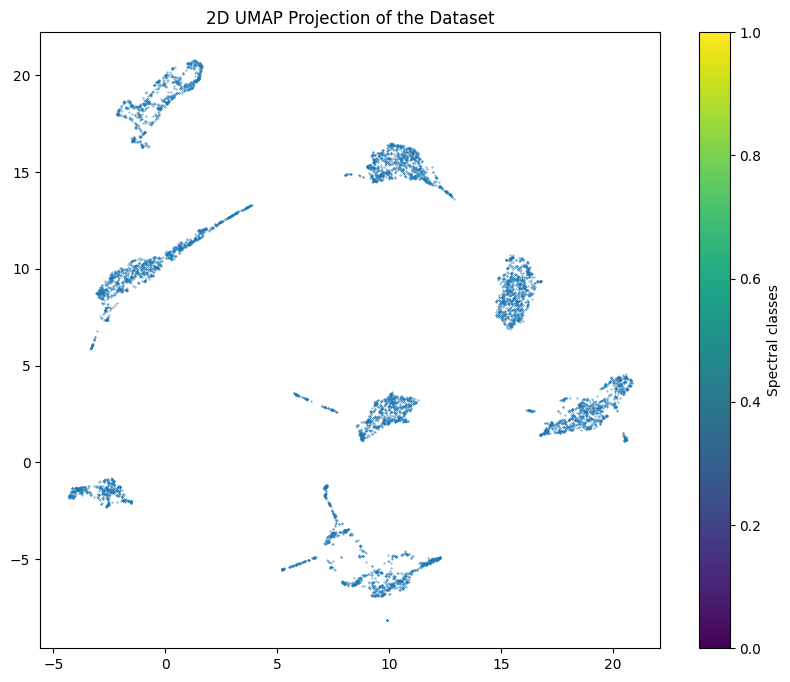

In [98]:
umap_projection_2d(HSI)

Below is a graph based on ground truth? Still working throguh documenation to decipher what this line of code does, specifically.


In [129]:
def show_clusterable_embedding(hsi_data, ground_truth):
  data_reshaped = hsi_data.reshape(-1, hsi_data.shape[2])

  clusterable_embedding = umap.UMAP(
      n_neighbors=30,
      min_dist=0.0,
      n_components=2,
      random_state=42,
  ).fit_transform(data_reshaped)

  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
              c=ground_truth, s=0.1, cmap='Spectral');

  return clusterable_embedding, data_reshaped

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


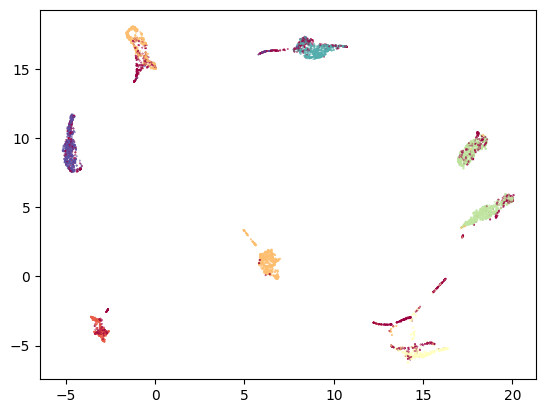

In [130]:
clust_emb, reshaped_hsi = show_clusterable_embedding(HSI, GT)

In [101]:
#Adjusting just salinas A for the label 0 difference, but not adjusting any of the other datasets and then we graph
#Technically did this above but we show this with the proper labels!

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def two_d_mapping_labeled(ground_truth, clusterable_embedding, dataset_name, is_salinasA=False):
    n_classes = np.max(ground_truth) + 1
    spectral_cmap = plt.cm.get_cmap('Spectral', n_classes)

    if is_salinasA:
        colors = spectral_cmap(np.linspace(0, 1, n_classes))
        colors[0] = [0, 0, 0, 1]  # (class 0) to black
    else:
        colors = spectral_cmap(np.linspace(0, 1, n_classes))

    new_camp = ListedColormap(colors)

    plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
                c=ground_truth, s=0.1, cmap=new_camp)
    plt.colorbar(ticks=np.arange(n_classes))
    plt.title(f'2D mapping of {dataset_name}, {"including class 0" if not is_salinasA else "excluding class 0"}', fontsize=18)
    plt.show()

<ipython-input-101-82ce86868c75>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  spectral_cmap = plt.cm.get_cmap('Spectral', n_classes)


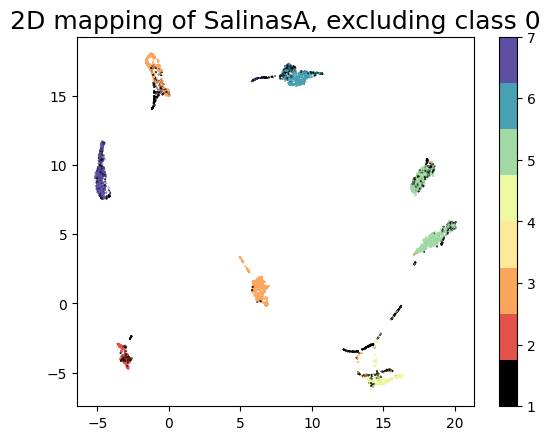

In [102]:
two_d_mapping_labeled(GT,clust_emb, dataset_name = 'SalinasA',  is_salinasA = True)

In [103]:
!pip install ffmpeg

In [139]:
#save for dimensionality purposes
from matplotlib.animation import FuncAnimation


def draw_umap(data_reshaped, ground_truth, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data_reshaped);
    fig = plt.figure()

    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=ground_truth, s=4)
        plt.title(title, fontsize=18)
        def update(frame):
            ax.view_init(elev=10, azim=frame)
            return fig,
        ani = FuncAnimation(fig, update, frames=range(0, 360, 2), blit=True)

        plt.show()
        ani.save('umap_rotation.mp4', writer='ffmpeg', fps=30)
    return u


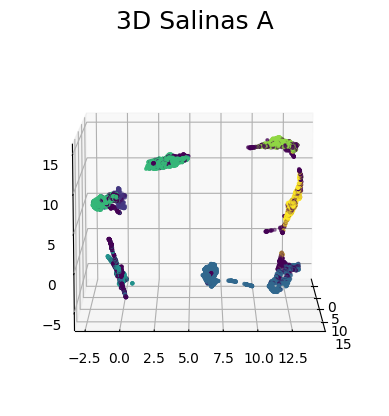

In [105]:
u = draw_umap(data_reshaped = reshaped_hsi, n_components=3,title='3D Salinas A')


Above are 2d plots and 3d plots, where UMAP is applied to the SalinasA dataset. Calling draw_umap automatically saves a video of a rotation of the 3d plot to the drive, clicking on it on the left hand tab allows for easy download and access.

Note: every time you run draw_umap, the video will be overwritten. If you want to save previous iterations in drive, make sure to rename in draw_umap.

Additionally, the mp4 video will not be ready until the cell has completed running.

Now, we seek to perform a k-means clustering, based on a umap dimensionality reduced dataset. Below is a function that works for all datasets(make sure to specify param)

In [142]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

def k_means_with_umap(dim_reduced_data, ground_truth):

  GT_flat = ground_truth.flatten()
  num_clusters = len(np.unique(GT_flat))


  # num_clusters = len(np.unique(GT_flat)) - (1 if 0 in GT_flat else 0)  # Adjust based on whether '0' should be excluded
  kmeans = KMeans(n_clusters=num_clusters, random_state=42)
  labels = kmeans.fit_predict(dim_reduced_data)

  ari = adjusted_rand_score(GT_flat, labels)
  print("UMAP Adjusted Rand Index (ARI):", ari)
  return GT_flat, labels


We check the results from clustering based on kmeans to a regular PCA, below:

In [107]:
gt_umap_3, labels_umap_3 = k_means_with_umap(u,GT)

UMAP Adjusted Rand Index (ARI): 0.5421327288138919


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [144]:
from sklearn.decomposition import PCA

def kmeans_with_pca(data,n_components, ground_truth):
  GT_flat_PCA = ground_truth.flatten()

  pca = PCA(n_components)
  data_reduced = pca.fit_transform(data)

  num_clusters = len(np.unique(GT_flat_PCA))
  # - (1 if 0 in GT_flat_PCA else 0)
  kmeans = KMeans(n_clusters=num_clusters, random_state=42)
  labels = kmeans.fit_predict(data_reduced)

  # Calculate Adjusted Rand Index (ARI)
  ari = adjusted_rand_score(GT_flat_PCA, labels)
  print("PCA Adjusted Rand Index (ARI):", ari)
  return GT_flat_PCA, labels


In [109]:
gt_flat_pca_3, labels_pca_3 = kmeans_with_pca(reshaped_hsi,3, GT)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


PCA Adjusted Rand Index (ARI): 0.3791122936600893


In [110]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

def calculate_aligned_accuracy(true_labels, cluster_labels):
    cm = confusion_matrix(true_labels, cluster_labels)

    row_ind, col_ind = linear_sum_assignment(-cm)
    label_mapping = {cluster_label: true_label for cluster_label, true_label in zip(col_ind, row_ind)}
    aligned_labels = [label_mapping[label] for label in cluster_labels]

    accuracy = np.mean(np.array(aligned_labels) == np.array(true_labels))

    return accuracy

In [111]:
print(calculate_aligned_accuracy(gt_umap_3, labels_umap_3))
print(calculate_aligned_accuracy(gt_flat_pca_3, labels_pca_3))


0.6993555617820117
0.5623423928271224


We note that the ARI using UMAP alone for dimensionality reduction, then running k-means gives an ARi of 0.54, whereas using PCA alone gives an ARI of 0.379.

Below is a quick check to see the difference in using UMAP to map to different dimensions.

In [112]:
four_d_plot = draw_umap(data_reshaped = reshaped_hsi, n_components=4,title='3D Salinas A')
gt_umap_4,lbl_umap_4 = k_means_with_umap(four_d_plot,GT)
gt_pca_4, lbl_pca_4 = kmeans_with_pca(reshaped_hsi,4, GT)

print(calculate_aligned_accuracy(gt_umap_4, lbl_umap_4))
print(calculate_aligned_accuracy(gt_pca_4, lbl_pca_4))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


UMAP Adjusted Rand Index (ARI): 0.5424716849509427
PCA Adjusted Rand Index (ARI): 0.3902091990464167
0.6994956570467918
0.5678061081535444


<Figure size 640x480 with 0 Axes>

Now, we do the same for diff dimensions, so we can create a comparison for the tradeoff in dimensions and performance:

In [113]:
two_d_plot = draw_umap(data_reshaped = reshaped_hsi, n_components=2,title='3D Salinas A')
gt_umap_2,lbl_umap_2 = k_means_with_umap(two_d_plot,GT)
gt_pca_2, lbl_pca_2 = kmeans_with_pca(reshaped_hsi,2, GT)

print(calculate_aligned_accuracy(gt_umap_2, lbl_umap_2))
print(calculate_aligned_accuracy(gt_pca_2, lbl_pca_2))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


UMAP Adjusted Rand Index (ARI): 0.5317016069049505
PCA Adjusted Rand Index (ARI): 0.3175238069488508
0.6979546091342113
0.52759876716167


<Figure size 640x480 with 0 Axes>

In [114]:
five_d_plot = draw_umap(data_reshaped = reshaped_hsi, n_components=5,title='3D Salinas A')
gt_umap_5,lbl_umap_5 = k_means_with_umap(five_d_plot,GT)
gt_pca_5, lbl_pca_5 = kmeans_with_pca(reshaped_hsi,5, GT)

print(calculate_aligned_accuracy(gt_umap_5, lbl_umap_5))
print(calculate_aligned_accuracy(gt_pca_5, lbl_pca_5))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


UMAP Adjusted Rand Index (ARI): 0.541651080450533
PCA Adjusted Rand Index (ARI): 0.3983836359444544
0.6992154665172318
0.572289156626506


<Figure size 640x480 with 0 Axes>

In [115]:
six_d_plot = draw_umap(data_reshaped = reshaped_hsi, n_components=6,title='3D Salinas A')
gt_umap_6,lbl_umap_6 = k_means_with_umap(six_d_plot,GT)
gt_pca_6, lbl_pca_6 = kmeans_with_pca(reshaped_hsi,6,GT)

print(calculate_aligned_accuracy(gt_umap_6, lbl_umap_6))
print(calculate_aligned_accuracy(gt_pca_6, lbl_pca_6))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


UMAP Adjusted Rand Index (ARI): 0.541651080450533


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


PCA Adjusted Rand Index (ARI): 0.3983836359444544
0.6992154665172318
0.572289156626506


<Figure size 640x480 with 0 Axes>

In [116]:
one_d_plot = draw_umap(data_reshaped = reshaped_hsi, n_components=1,title='3D Salinas A')
gt_umap_1,lbl_umap_1 = k_means_with_umap(one_d_plot,GT)
gt_pca_1, lbl_pca_1 = kmeans_with_pca(reshaped_hsi,1,GT)

print(calculate_aligned_accuracy(gt_umap_1, lbl_umap_1))
print(calculate_aligned_accuracy(gt_pca_1, lbl_pca_1))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


UMAP Adjusted Rand Index (ARI): 0.35741281705175704


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


PCA Adjusted Rand Index (ARI): 0.3290387989573241
0.5798543009246288
0.5619221070327823


<Figure size 640x480 with 0 Axes>

finally. generated plot for comparison below


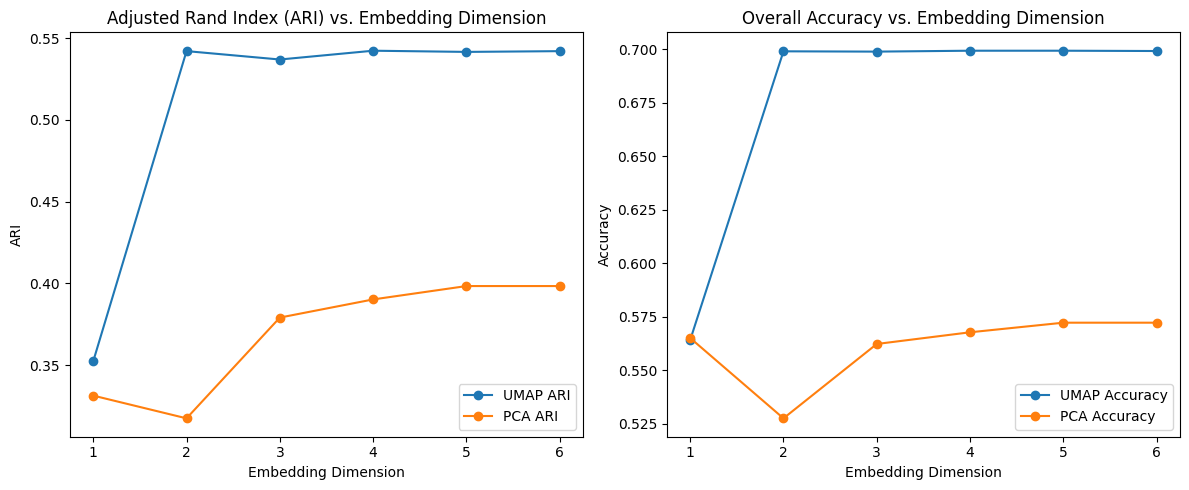

In [117]:
import matplotlib.pyplot as plt
#in the future i can just iterate through a loop that was so inefficient..
#also update this bc i changed all the functions up.

dimensions = [1, 2, 3, 4, 5, 6]
umap_ari = [0.3524038218386362, 0.541992, 0.536857, 0.542234, 0.541510, 0.541969]
pca_ari = [0.3314176947822812, 0.317524, 0.379112, 0.390209, 0.398384, 0.398384]

umap_accuracy = [0.564163631269263, 0.699075, 0.698935, 0.699356, 0.699356, 0.699215]
pca_accuracy = [0.5651442981227235
, 0.527599, 0.562342, 0.567806, 0.572289, 0.572289]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(dimensions, umap_ari, label='UMAP ARI', marker='o')
plt.plot(dimensions, pca_ari, label='PCA ARI', marker='o')
plt.title('Adjusted Rand Index (ARI) vs. Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('ARI')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dimensions, umap_accuracy, label='UMAP Accuracy', marker='o')
plt.plot(dimensions, pca_accuracy, label='PCA Accuracy', marker='o')
plt.title('Overall Accuracy vs. Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('Accuracy')

plt.legend()

plt.tight_layout()
plt.show()


We see that as embednig dimension increases, the overall accuracy of UMAP is relatively stable - this is (my guess) most likely due to the umap utilizing fuzzy unions (need to watch video on this)

Now, we try the indian pines dataset:

In [118]:
#IG it is worth to write all of the steps out. thats my goal after lunch then i can have an easier time
#running eveyrthing instaed of like scrolling..

#omg i want a monitor
#that would be so so so sos ossdfoisoidfos nice

#arent there monitors in the library

In [122]:
Indian_pines_path = '/content/drive/MyDrive/Indian_pines_corrected.mat'
Indian_pines_gt_path = '/content/drive/MyDrive/Indian_pines_gt.mat'

X_ind, M_ind, N_ind, D_ind, HSI_ind, GT_ind, Y_ind, n_ind, K_ind = loadHSI(Indian_pines_path, Indian_pines_gt_path, 'indian_pines_corrected', 'indian_pines_gt')

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<ipython-input-97-382f9e0ccfd8>:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1, cmap='Spectral')


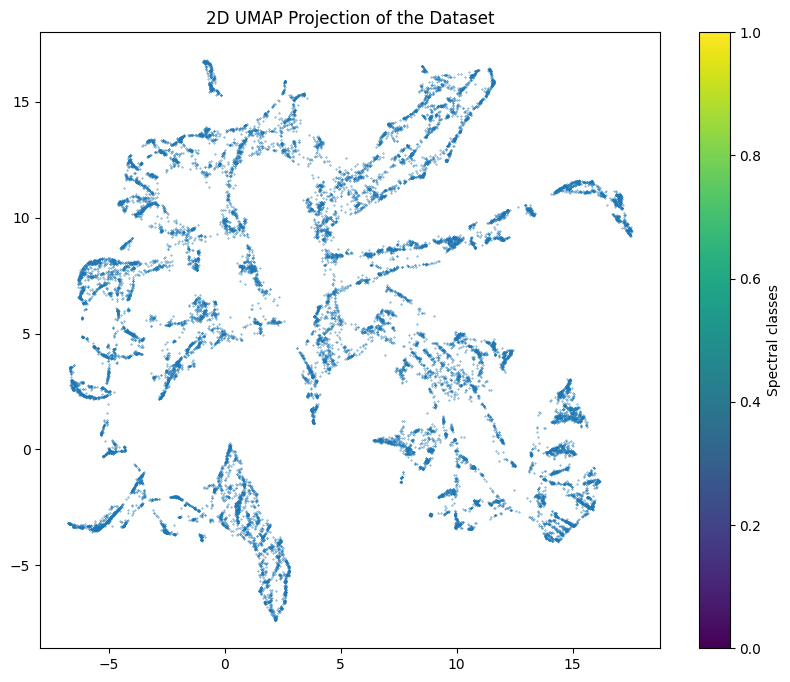

In [123]:
umap_projection_2d(HSI_ind)

In [132]:
print(HSI_ind.shape)
print(GT_ind.shape)

(145, 145, 200)
(145, 145)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


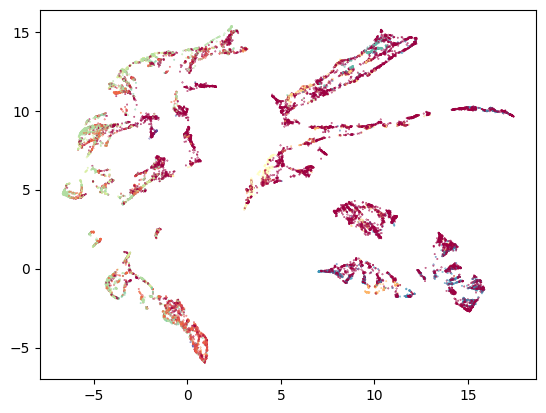

In [131]:
indian_clust_emb, reshaped_indian = show_clusterable_embedding(HSI_ind,GT_ind)

<ipython-input-101-82ce86868c75>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  spectral_cmap = plt.cm.get_cmap('Spectral', n_classes)


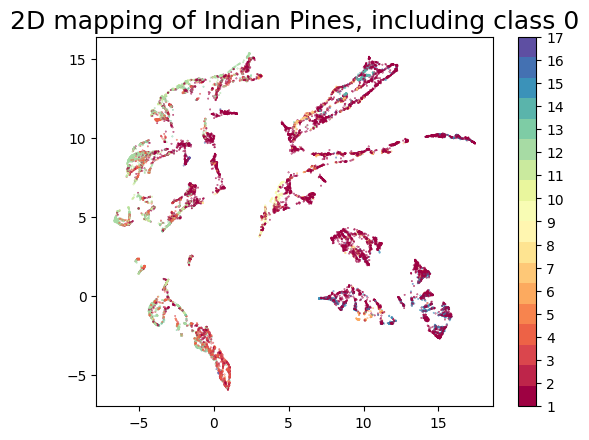

In [134]:
two_d_mapping_labeled(GT_ind, indian_clust_emb,dataset_name='Indian Pines')




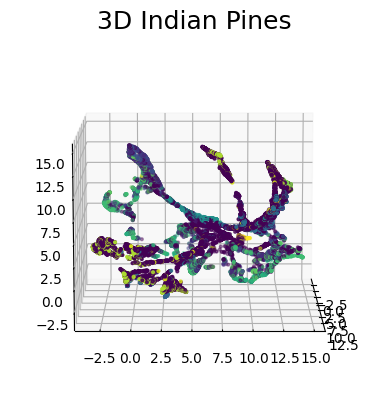

In [140]:
umap_indian = draw_umap(data_reshaped = reshaped_indian, ground_truth = GT_ind, n_components=3, title='3D Indian Pines')

In [149]:
gt_umap_3, labels_umap_3 = k_means_with_umap(umap_indian,GT_ind)

gt_flat_pca_3, labels_pca_3 = kmeans_with_pca(reshaped_indian,3, GT_ind)

print(calculate_aligned_accuracy(gt_umap_3, labels_umap_3))
print(calculate_aligned_accuracy(gt_flat_pca_3, labels_pca_3))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


UMAP Adjusted Rand Index (ARI): 0.06298830264017014


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


PCA Adjusted Rand Index (ARI): 0.05149414565465823
0.23205707491082045
0.236718192627824


In [151]:
umap_indian = draw_umap(data_reshaped = reshaped_indian, ground_truth = GT_ind, n_components=2)

gt_umap_2, labels_umap_2 = k_means_with_umap(umap_indian,GT_ind)

gt_flat_pca_2, labels_pca_2 = kmeans_with_pca(reshaped_indian,2, GT_ind)

print(calculate_aligned_accuracy(gt_umap_2, labels_umap_2))
print(calculate_aligned_accuracy(gt_flat_pca_2, labels_pca_2))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


UMAP Adjusted Rand Index (ARI): 0.05965729796541598


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


PCA Adjusted Rand Index (ARI): 0.051888299247743644
0.22344827586206897
0.22482758620689655


<Figure size 640x480 with 0 Axes>

In [150]:
umap_indian = draw_umap(data_reshaped = reshaped_indian, ground_truth = GT_ind, n_components=4)

gt_umap_4, labels_umap_4 = k_means_with_umap(umap_indian,GT_ind)

gt_flat_pca_4, labels_pca_4 = kmeans_with_pca(reshaped_indian,4, GT_ind)

print(calculate_aligned_accuracy(gt_umap_4, labels_umap_4))
print(calculate_aligned_accuracy(gt_flat_pca_4, labels_pca_4))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


UMAP Adjusted Rand Index (ARI): 0.058587185571163186


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


PCA Adjusted Rand Index (ARI): 0.05804724850736347
0.23957193816884662
0.24090368608799048


<Figure size 640x480 with 0 Axes>

In [147]:
umap_indian = draw_umap(data_reshaped = reshaped_indian, ground_truth = GT_ind, n_components=5)

gt_umap_5, labels_umap_5 = k_means_with_umap(umap_indian,GT_ind)

gt_flat_pca_5, labels_pca_5 = kmeans_with_pca(reshaped_indian,5, GT_ind)

print(calculate_aligned_accuracy(gt_umap_5, labels_umap_5))
print(calculate_aligned_accuracy(gt_flat_pca_5, labels_pca_5))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


UMAP Adjusted Rand Index (ARI): 0.05111911257461799


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


PCA Adjusted Rand Index (ARI): 0.05519864067226769
0.21483947681331747
0.24651605231866824


<Figure size 640x480 with 0 Axes>

In [153]:
umap_indian = draw_umap(data_reshaped = reshaped_indian, ground_truth = GT_ind, n_components=6)

gt_umap_6, labels_umap_6 = k_means_with_umap(umap_indian,GT_ind)

gt_flat_pca_6, labels_pca_6 = kmeans_with_pca(reshaped_indian,6, GT_ind)

print(calculate_aligned_accuracy(gt_umap_6, labels_umap_6))
print(calculate_aligned_accuracy(gt_flat_pca_6, labels_pca_6))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


UMAP Adjusted Rand Index (ARI): 0.05189580265774312


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


PCA Adjusted Rand Index (ARI): 0.055732823770434585
0.2307728894173603
0.24746730083234245


<Figure size 640x480 with 0 Axes>

In [152]:
umap_indian = draw_umap(data_reshaped = reshaped_indian, ground_truth = GT_ind, n_components=1)

gt_umap_1, labels_umap_1 = k_means_with_umap(umap_indian,GT_ind)

gt_flat_pca_1, labels_pca_1 = kmeans_with_pca(reshaped_indian,1, GT_ind)

print(calculate_aligned_accuracy(gt_umap_1, labels_umap_1))
print(calculate_aligned_accuracy(gt_flat_pca_1, labels_pca_1))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


UMAP Adjusted Rand Index (ARI): 0.03841402738873913


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


PCA Adjusted Rand Index (ARI): 0.05626702427006589
0.1913912009512485
0.2119857312722949


<Figure size 640x480 with 0 Axes>

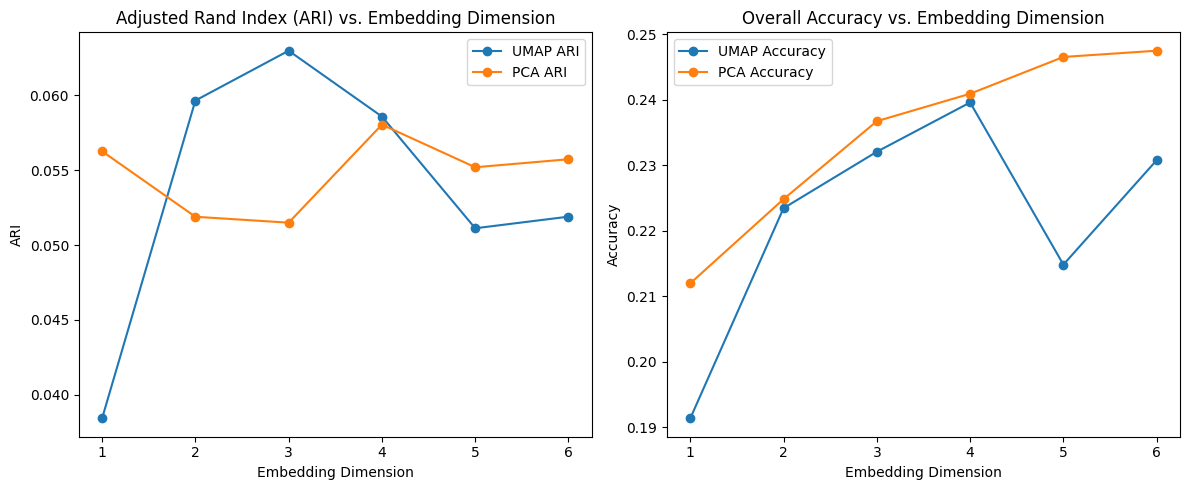

In [154]:
import matplotlib.pyplot as plt
#in the future i can just iterate through a loop that was so inefficient..
#also update this bc i changed all the functions up.

dimensions = [1, 2, 3, 4, 5, 6]
umap_ari = [0.03841402738873913, 0.05965729796541598, 0.06298830264017014, 0.058587185571163186, 0.05111911257461799, 0.05189580265774312]
pca_ari = [0.05626702427006589, 0.051888299247743644, 0.05149414565465823, 0.05804724850736347, 0.05519864067226769, 0.055732823770434585]

umap_accuracy = [0.1913912009512485, 0.22344827586206897, 0.23205707491082045, 0.23957193816884662, 0.21483947681331747, 0.2307728894173603]
pca_accuracy = [0.2119857312722949, 0.22482758620689655, 0.236718192627824, 0.24090368608799048, 0.24651605231866824, 0.24746730083234245]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(dimensions, umap_ari, label='UMAP ARI', marker='o')
plt.plot(dimensions, pca_ari, label='PCA ARI', marker='o')
plt.title('Adjusted Rand Index (ARI) vs. Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('ARI')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dimensions, umap_accuracy, label='UMAP Accuracy', marker='o')
plt.plot(dimensions, pca_accuracy, label='PCA Accuracy', marker='o')
plt.title('Overall Accuracy vs. Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('Accuracy')

plt.legend()

plt.tight_layout()
plt.show()


Aryaman - can you please run this with Pavia?